In [1]:
import random
import numpy as np
import kf_book.book_plots as book_plots
import matplotlib.pyplot as plt

from kf_book.book_plots import figsize, set_figsize
from ipywidgets import interact, IntSlider

from scipy.ndimage.filters import convolve
from scipy.ndimage.interpolation import shift

In [2]:
belief = np.array([1./10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [3]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
print(hallway)

[1 1 0 0 0 0 0 0 1 0]


In [4]:
belief = hallway * 1/3
print(belief)

[0.33333333 0.33333333 0.         0.         0.         0.
 0.         0.         0.33333333 0.        ]


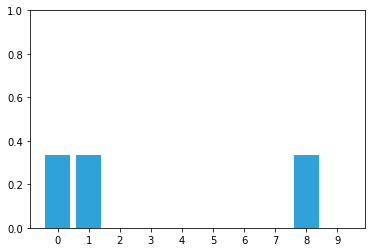

In [5]:
book_plots.bar_plot(belief)

In [6]:
belief = np.array([0]*10)
belief[1] = 1
print(belief)

[0 1 0 0 0 0 0 0 0 0]


$\Huge Scale = \frac{Prob_{correct}}{Prob_{incorrect}} = \frac{Prob_{correct}}{1 - Prob_{correct}}$

Belief:  [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
Sum:  1.6000000000000003


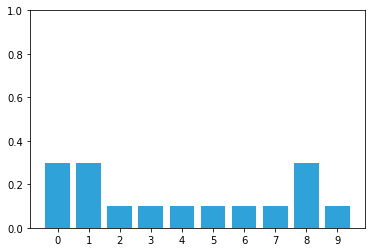

In [7]:
def update_belief(hall, belief, z, correct_scale = 3.):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale
belief = np.array([0.1] * 10)
reading = 1
update_belief(hallway, belief, z = reading, correct_scale = 3.)
print('Belief: ', belief)
print('Sum: ', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

In [8]:
belief / sum(belief)

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

Sum:  1.0
Probability of door:  0.1875
probability of wall:  0.06249999999999999


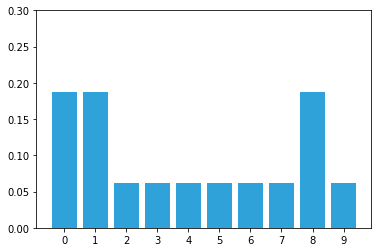

In [9]:
def scale_update(hall, belief, z, z_prob):
    scale = z_prob/(1 - z_prob)
    belief[hall == z] *= scale
    belief = belief/sum(belief)
    return belief 

belief = np.array([0.1] * 10)
belief = scale_update(hallway, belief, 1, z_prob = 0.75)

print('Sum: ', sum(belief))
print('Probability of door: ', belief[0])
print('probability of wall: ', belief[2])
book_plots.bar_plot(belief, ylim = (0, 0.3))


$\Huge Posterior = \frac{Likelihood\times Prior}{Normalization}$

In [10]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob/(1 - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall == z]  *= scale
    return likelihood*belief/(sum(likelihood*belief))

def update(likelihood, prior):
    return likelihood * prior/sum(likelihood * prior)

In [11]:
def lh_hallway(hall, z, z_prob):
    try:
        scale = z_prob/(1 - z_prob)
    except ZeroDivisionError:
        scale = 1e8
    
    likelihood = np.ones(len(hall));
    likelihood[hall == z] *= scale
    return likelihood

belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z = 1, z_prob = 0.75)
posterior = update(likelihood, belief)
print(posterior)

[0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]


In [12]:
def perfect_predict(belief, move):
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[i - move]
    return result


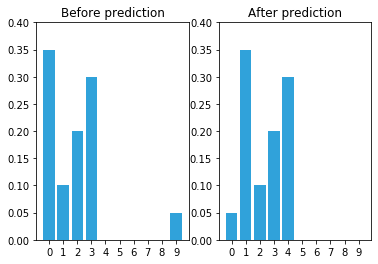

In [13]:
belief = np.array([0.35, 0.1, 0.2, 0.3, 0, 0, 0, 0, 0, 0.05])
plt.subplot(121)
book_plots.bar_plot(belief, title = 'Before prediction', ylim = (0, 0.4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title = 'After prediction', ylim = (0, 0.4))

In [14]:
belief = np.array([0.35, 0.1, 0.2, 0.3, 0, 0, 0, 0, 0, 0.05])
beliefs = []
for _ in range(20):
    belief = perfect_predict(belief, 1)
    beliefs.append(belief)

def simulate(time_step):
    book_plots.bar_plot(beliefs[time_step], ylim = (0, 0.4))

interact(simulate, time_step = IntSlider(value = 0, max = len(beliefs) - 1))

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

<function __main__.simulate(time_step)>

Calculate the prior of position 5:

$Reach \; position \; 5 =\begin{cases}
                    Position \; 2 \; move \; 3, & Over\\
                    Position \; 3 \; move \; 2, & Correct\\
                    Position \; 4 \; move \; 1, & Under
                    \end{cases}$

In [15]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = ( 
            belief[i - move - 1] * p_over +
            belief[i - move] * p_correct + 
            belief[i - move + 1] * p_under
        )
    return prior

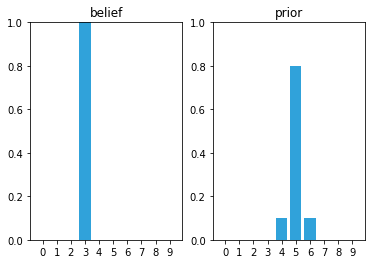

In [16]:
belief = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
prior = predict_move(belief, 2, 0.1, 0.8, 0.1)
book_plots.plot_belief_vs_prior(belief, prior)

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

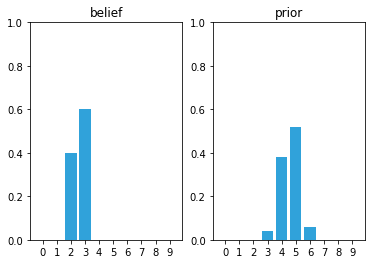

In [17]:
belief = np.array([0, 0, 0.4, 0.6, 0, 0, 0, 0, 0, 0])
prior = predict_move(belief, 2, 0.1, 0.8, 0.1)
book_plots.plot_belief_vs_prior(belief, prior)
prior


In [18]:
belief = np.array([0] * 10)
belief[0] = 1

for i in range(100):
    belief = predict_move(belief, 1, 0.1, 0.8, 0.1)
    beliefs.append(belief)

def show_prior(step):
    book_plots.bar_plot(beliefs[step-1])
    plt.title('Step:{}'.format(step))
interact(show_prior, step = IntSlider(value = 1, max = len(beliefs)))

interactive(children=(IntSlider(value=1, description='step', max=120), Output()), _dom_classes=('widget-intera…

<function __main__.show_prior(step)>

In [19]:
print('Final belief: ', belief)

Final belief:  [0.10407069 0.10329322 0.10125784 0.09874205 0.09670682 0.09592945
 0.09670682 0.09874205 0.10125784 0.10329322]


 ## Convolution 
 
 ### 1. For Continuous function
 
 $$\Huge (f * g) = \int_{0}^{t} f(\tau)g(t - \tau) d\tau$$

 ### 2. For Discrete function
 
 $$\Huge (f  * g)[t] = \sum_{\tau = 0}^t f[\tau]g[t - \tau] $$


In [20]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN-1)/2)
    
    prior = np.zeros(N)
    
    for i in range(N):
        for k in range(kN):
            index = (i + (width - k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

In [21]:
def predict(pdf, offset, kernel, mode='wrap', cval=0.):
    if mode == 'wrap':
        return convolve(np.roll(pdf, offset), kernel, mode='wrap')

    return convolve(shift(pdf, offset, cval=cval), kernel,
                    cval=cval, mode='constant')

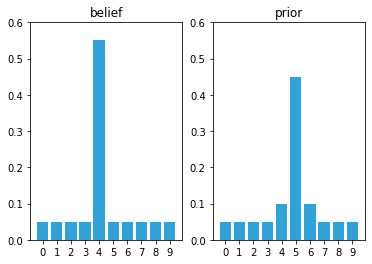

In [22]:
belief = np.array([0.05] * 10)
belief[4] = 0.55
prior = predict(belief, offset = 1, kernel = [0.1, 0.8, 0.1])
book_plots.plot_belief_vs_prior(belief, prior, ylim = (0, 0.6))

In [23]:
belief = np.array([0.05] * 10)
belief[0] = 0.55
beliefs = []
for i in range(100):
    belief = predict(belief, offset = 1, kernel = [0.1, 0.8, 0.1])
    beliefs.append(belief)
def show_prior(step):
    book_plots.bar_plot(beliefs[step-1])
    plt.title('Step:{}'.format(step))
interact(show_prior, step = IntSlider(value = 1, max = len(beliefs)))

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

<function __main__.show_prior(step)>

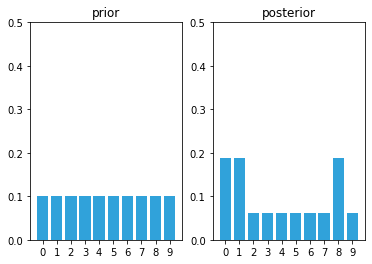

In [24]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z = 1, z_prob = 0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim = (0, 0.5))

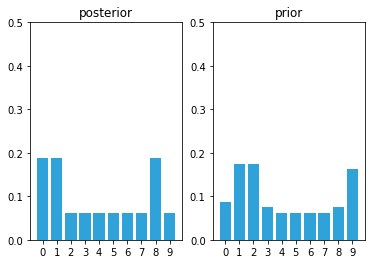

In [25]:
kernel = (0.1, 0.8, 0.1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim = (0, 0.5))

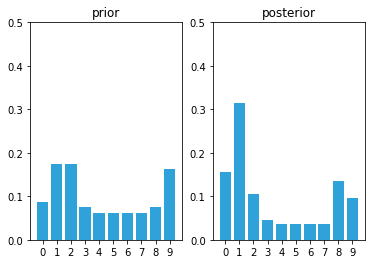

In [26]:
likelihood = lh_hallway(hallway, z = 1, z_prob = 0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim = (0, 0.5))

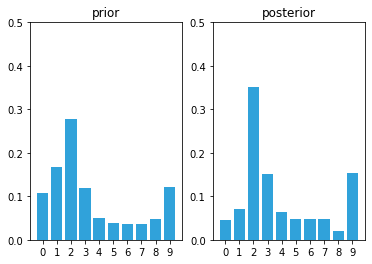

In [27]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z = 0, z_prob = 0.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim = (0, 0.5))

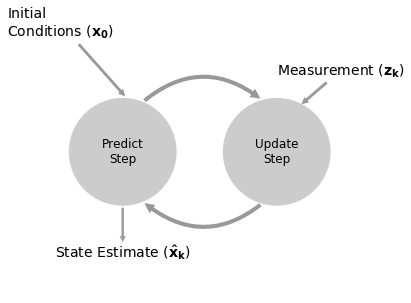

In [28]:
book_plots.predict_update_chart()

## Initialization

1. Initialize our belief in the state

## Predict

1. Based on the system behavior, predict state for the next time step

2. Adjust belief to account for the uncertainty in prediction

## Update

1. Get a measurement and associated belief about its accuracy

2. Compute how likely it is the measurement matches each state

3. Update state belief with this likelihood


In [29]:
def discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway = hallway):
    posterior = np.array([0.1]  * 10)
    priors, posteriors = [], []
    
    for i,z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)
        
        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors

def plot_posterior(posteriors, i):
    plt.title('Posterior')
    book_plots.bar_plot(hallway, c = 'k')
    book_plots.bar_plot(posteriors[i], ylim = (0, 1.0))
    plt.axvline(i % len(hallway), lw = 5)
    
def plot_prior(priors, i):
    plt.title('Prior')
    book_plots.bar_plot(hallway, c = 'k')
    book_plots.bar_plot(priors[i], ylim = (0, 1.0), c = '#ff8015')
    plt.axvline(i % len(hallway), lw = 5)

def animate_discrete_bayes(step):
    step -= 1
    i = step // 2
    
    if step % 2 == 0:
        plot_prior(priors, i)
    else:
        plot_posterior(posteriors, i)

In [30]:
kernel = (0.1, 0.8, 0.1)
z_prob = 1.0
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
zs = [hallway[i % len(hallway)] for i in range(50)]
priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob)
interact(animate_discrete_bayes, step = IntSlider(value = 1, max = len(zs) * 2))

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

<function __main__.animate_discrete_bayes(step)>

In [31]:
hallway = np.array([1, 0, 1, 0, 0] * 2)
kernel = (0.1, 0.8, 0.1)
prior = np.array([0.1] * 10)
zs = [1, 0, 1, 0, 0, 1]
z_pron = 0.75
priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes, step = IntSlider(value = 12, max = len(zs) * 2))

interactive(children=(IntSlider(value=12, description='step', max=12), Output()), _dom_classes=('widget-intera…

<function __main__.animate_discrete_bayes(step)>

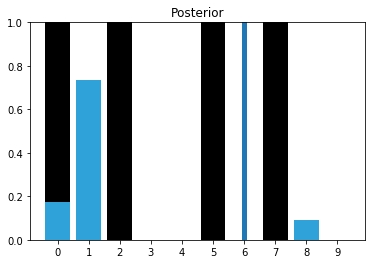

In [32]:
measurements = [1, 0, 1, 0, 0, 1, 1]
priors, posteriors = discrete_bayes_sim(prior, kernel, measurements, z_prob)
plot_posterior(posteriors, 6)

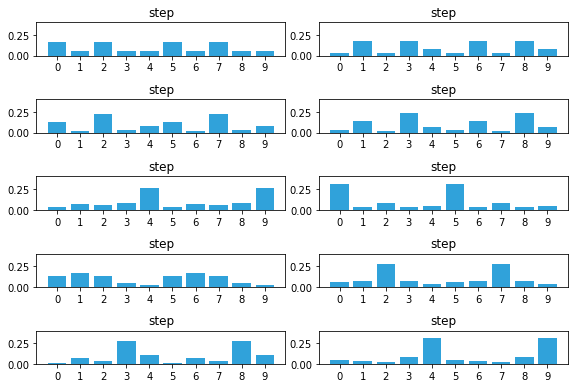

In [33]:
with figsize(y = 5.5):
    measurements = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
    for i,m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z = m, z_prob = 0.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(5, 2, i+1)
        book_plots.bar_plot(posterior, ylim = (0, 0.4), title ='step'.format(i + 1))
    plt.tight_layout()

In [34]:
class Train(object):
    def __init__(self, track_len, kernel = [1.], sensor_accuracy = 0.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy
    
    def move(self, distance = 1):
        self.pos += distance
        
        r = np.random.random()
        s = 0
        offset = -(len(self.kernel) - 1)/2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos
    
    def sense(self):
        pos = self.pos
        
        if random.random() > self.sensor_accuracy:
            if np.random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

In [35]:
def train_filter(iterations, kernel, sensor_accuracy, move_distance, do_print = True):
    track = np.linspace(0,9,10).astype('int')
    prior = np.array([0.9] + [0.01] * 9)
    posterior = prior[:]
    prior = prior/ sum(prior)
    
    robot = Train(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        # Move the robot
        robot.move(distance = move_distance)
        
        # Perform prediction
        prior = predict(posterior, move_distance, kernel)
        
        # Update the filter
        m = robot.sense()
        likelihood = lh_hallway(track, m, sensor_accuracy)
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)
        
        if do_print:
            print('''time {}: pos{}, sensed {}, at position {}'''.format(i, robot.pos, m, track[robot.pos]))
            
            print('''Estimated position is {} with confidence {:.4f}%'''.format(index, posterior[index]*100))
    
    book_plots.bar_plot(posterior)
        
    if do_print:
        print()
        print('final postion is ', robot.pos)
        index = np.argmax(posterior)
        print('''Estimated position is {} with confidence {:.4f}%'''.format(index, posterior[index] * 100))
            
        

time 0: pos4, sensed 4, at position 4
Estimated position is 4 with confidence 99.9900%
time 1: pos8, sensed 8, at position 8
Estimated position is 8 with confidence 100.0000%
time 2: pos2, sensed 2, at position 2
Estimated position is 2 with confidence 100.0000%
time 3: pos6, sensed 6, at position 6
Estimated position is 6 with confidence 100.0000%

final postion is  6
Estimated position is 6 with confidence 100.0000%


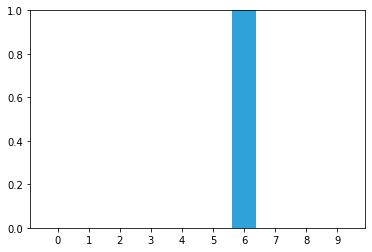

In [36]:
train_filter(4, kernel = [1], sensor_accuracy = 0.999, move_distance = 4, do_print = True)

time 0: pos4, sensed 4, at position 4
Estimated position is 4 with confidence 96.0390%
time 1: pos8, sensed 8, at position 8
Estimated position is 8 with confidence 96.8094%
time 2: pos2, sensed 2, at position 2
Estimated position is 2 with confidence 96.9180%
time 3: pos7, sensed 7, at position 7
Estimated position is 7 with confidence 52.4061%

final postion is  7
Estimated position is 7 with confidence 52.4061%


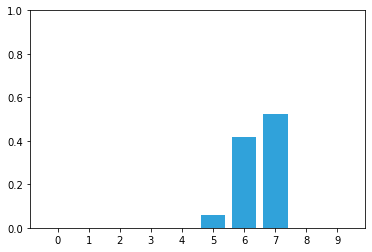

In [37]:
np.random.seed(5)
train_filter(4, kernel = [0.1, 0.8, 0.1], sensor_accuracy = 0.9, move_distance = 4, do_print = True)

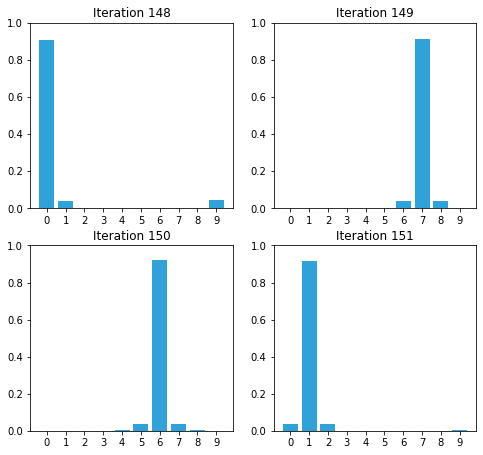

In [38]:
with figsize(y = 7.5):
    for i in range(4):
        np.random.seed(5)
        
        plt.subplot(221+i)
        train_filter(148+i, kernel = [0.1, 0.8, 0.1], sensor_accuracy = 0.8, move_distance = 4, do_print = False)
        plt.title('Iteration {}'.format(148+i))

$$\Huge Posterior = \frac{Likelihood \times prior}{Normalization \; factor}$$

$$\Large Updated \; knowledge = \lvert\lvert Likelihood \; of \; new \; knowledge \times Prior \; knowledge\rvert\rvert$$